<div style="text-align: right"> York University - ML1030 - Julia Mitroi </div>

# Sentiment Analysis for Movie Reviews

## GloVe + CNN_LSTM

### Installing libraries and packages

In [1]:
import os
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TreebankWordTokenizer 
from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

import re

import seaborn as sns

import random

import keras
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

from keras.models import Sequential, load_model, Model
from keras.layers import Dense, LSTM, Dropout , Embedding, Conv1D , MaxPooling1D , Input, Reshape , Masking , TimeDistributed
from keras.layers import Concatenate, BatchNormalization, Bidirectional, Activation, GlobalMaxPooling1D
from keras.preprocessing.sequence import TimeseriesGenerator, pad_sequences
from keras.callbacks import History, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.constraints import maxnorm
from keras.regularizers import l1_l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, precision_score, accuracy_score
from sklearn.metrics import recall_score , confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_reviews = pd.read_csv("train.tsv", sep="\t")

In [3]:
test_reviews = pd.read_csv("test.tsv", sep="\t")

### Data Cleaning

In [4]:
# Make reviews text lowercase
train_reviews['Phrase'] = train_reviews['Phrase'].str.lower()
test_reviews['Phrase'] = test_reviews['Phrase'].str.lower()

In [5]:
train_reviews['Phrase'].head()

0    a series of escapades demonstrating the adage ...
1    a series of escapades demonstrating the adage ...
2                                             a series
3                                                    a
4                                               series
Name: Phrase, dtype: object

In [6]:
# Leaving only letters from a-z and digits
train_reviews['Phrase'] = train_reviews['Phrase'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
test_reviews['Phrase'] = test_reviews['Phrase'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [7]:
# Removing HTML content
train_reviews['Phrase'] = [BeautifulSoup(text).get_text() for text in train_reviews['Phrase']]
test_reviews['Phrase'] = [BeautifulSoup(text).get_text() for text in test_reviews['Phrase']]

In [8]:
train_reviews['Phrase'].head()

0    a series of escapades demonstrating the adage ...
1    a series of escapades demonstrating the adage ...
2                                             a series
3                                                    a
4                                               series
Name: Phrase, dtype: object

In [9]:
# Tokenization

treebank_tokenizer = TreebankWordTokenizer()
lem = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(x):
    tk = treebank_tokenizer.tokenize(x)
    tk = [s.lower() for s in tk]
    return tk

In [10]:
sentences = train_reviews.Phrase.apply(preprocess)

In [11]:
sentences.head()

0    [a, series, of, escapades, demonstrating, the,...
1    [a, series, of, escapades, demonstrating, the,...
2                                          [a, series]
3                                                  [a]
4                                             [series]
Name: Phrase, dtype: object

In [12]:
os.getcwd()

'/Users/Julia/Desktop/ML1030_CAPSTONE_PROJECT-master'

In [14]:
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r' ,  encoding="utf8")
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model


model = loadGloveModel('/Users/Julia/Desktop/ML1030_CAPSTONE_PROJECT-master/glove.6B.100d.txt')

Loading Glove Model
Done. 400000  words loaded!


In [15]:
# Vectorization

def vectorize(sentences, B):
    
    lens = sentences.apply(lambda x:len(x))
    ebds = []
    tsteps = max(lens)
    
    X = np.zeros((len(sentences) , tsteps , B))
    
    for i in range(len(sentences)):
        
        words = sentences[i]
        k = tsteps -1
        
        for word in words[::-1] :
            try:
                X[i , k] = model[word]
                k = k - 1
            except:
                lens[i] = lens[i] - 1
                
    ntsteps = max(lens)
    
    return X[: , (tsteps - ntsteps): ]



sentences = sentences.reset_index(drop = True)

X = vectorize(sentences, 100)
Y = pd.get_dummies(train_reviews.Sentiment).values

model = None

In [16]:
print("X's shape :" , X.shape)
print("Y's shape :" , Y.shape)

X's shape : (156060, 48, 100)
Y's shape : (156060, 5)


In [17]:
 from keras.callbacks import EarlyStopping

In [18]:
# Model

def model(X , Y , 
          lstm_layers = [] , lstm_dropout = [],
          cnn_layers = [] , cnn_kernels = [] , cnn_dropout = [], 
          max_pooling_layers = [] , max_pooling = False ,
          dense_layers = [] , dense_dropout = [] ,
          ntest_sers = 400 , epochs = 10 , batch_size = 32 , lr = 0.001 , decay = 0 , beta_1 = 0.9 , beta_2 = 0.999):
        
        
    # training and testing set :
    length , timesteps , features = X.shape[0] , X.shape[1] , X.shape[2]

    target_shape = Y.shape[1]
    
    # Validation rate to pass to the Sequential Model :
    val_rate = ntest_sers/length
    
    
    # Model :
    
    history = History()
    checkpoint = ModelCheckpoint('model' , save_best_only=True)
   
    model = Sequential()
   
    
    # Conv Layers
    for i in range(len(cnn_layers)):
 
        model.add(Conv1D(cnn_layers[i] , cnn_kernels[i], input_shape=(X.shape[1], X.shape[2]) ,padding = 'same' ) )
        model.add(BatchNormalization())
        model.add(Activation('relu'))
  
        
        if max_pooling:
            model.add(MaxPooling1D(max_pooling_layers[i]))
    
    if len(lstm_layers) ==0:
        model.add(GlobalMaxPooling1D())
    
       
    
    # Bi-LSTM Layers
    for i in range(len(lstm_layers)):
        
        rsequs  = not (i == (len(lstm_layers) - 1))
        model.add(Bidirectional(LSTM(lstm_layers[i] , return_sequences = rsequs) , input_shape=(X.shape[1], X.shape[2]) )) 
        
        if len(lstm_dropout)>0:
            model.add(Dropout(lstm_dropout[i]))
                
            
    for i in range(len(dense_layers)):
         
        model.add(Dense(dense_layers[i] , activation = 'relu') )
        
        if len(dense_dropout)>0:
            model.add(Dropout(dense_dropout[i]))      
        
    model.add(Dense(target_shape , activation = 'softmax'))

    #adm = keras.optimizers.Adam(lr = lr , decay = decay)
    #sgd = keras.optimizers.SGD(lr=0.0001, nesterov=True, momentum=0.7, decay=1e-4)
    Nadam = keras.optimizers.Nadam(lr = lr , beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer= Nadam , metrics = ['accuracy'])
    
    early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
    
    # fitting the data
    model.fit(X, Y, epochs= epochs, batch_size=batch_size, validation_split = val_rate ,
              callbacks = [history, checkpoint, early_stopping])
    
    
    # loading best_model
    model = load_model('model')

              
    # loading best_model
    return model, min(history.history['val_loss'])

  

In [19]:
val = 1000

model = model( X , Y , 
               cnn_layers = [128], cnn_kernels = [3, 3] , cnn_dropout = [.5],
               lstm_layers = [128, 128] , lstm_dropout = [.5, .5],
               dense_layers = [64] , dense_dropout = [.2],
               batch_size = 256 , epochs = 10, ntest_sers = val , lr = 0.001)

Train on 155060 samples, validate on 1000 samples
Epoch 1/10
155060/155060 [==============================] - 1967s 13ms/step - loss: 1.0041 - acc: 0.5890 - val_loss: 0.9655 - val_acc: 0.5910
Epoch 2/10
155060/155060 [==============================] - 12305s 79ms/step - loss: 0.8978 - acc: 0.6299 - val_loss: 0.9469 - val_acc: 0.5890
Epoch 3/10
155060/155060 [==============================] - 5282s 34ms/step - loss: 0.8421 - acc: 0.6526 - val_loss: 0.9214 - val_acc: 0.6100
Epoch 4/10
155060/155060 [==============================] - 2253s 15ms/step - loss: 0.8018 - acc: 0.6706 - val_loss: 0.9020 - val_acc: 0.6210
Epoch 5/10
155060/155060 [==============================] - 2000s 13ms/step - loss: 0.7717 - acc: 0.6812 - val_loss: 0.9451 - val_acc: 0.6040
Epoch 6/10
155060/155060 [==============================] - 2095s 14ms/step - loss: 0.7428 - acc: 0.6934 - val_loss: 0.9382 - val_acc: 0.6280
Epoch 7/10
155060/155060 [==============================] - 2291s 15ms/step - loss: 0.7198 - acc:

Validation accuracy = 60.3%

### Model Performance

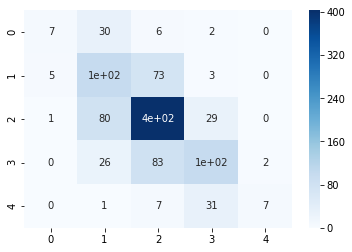

average accuracy: 0.621
precision: [0.53846154 0.42677824 0.70454545 0.61077844 0.77777778]
recall: [0.15555556 0.55737705 0.78557505 0.47887324 0.15217391]


In [20]:
# prediction
y_score = model[0].predict(X[-val:])
y_pred = np.argmax(y_score , axis = 1)

# True values
y_test = train_reviews.Sentiment.values[-val:]

# Confusion matrix
hmap = confusion_matrix(y_test , y_pred)
sns.heatmap(hmap , cmap = 'Blues' , annot = True)
plt.show()

# Metrics :
print('average accuracy:' , accuracy_score(y_test , y_pred))
print('precision:' , precision_score(y_test , y_pred , average = None))
print('recall:' , recall_score(y_test , y_pred , average = None))

class no : 0


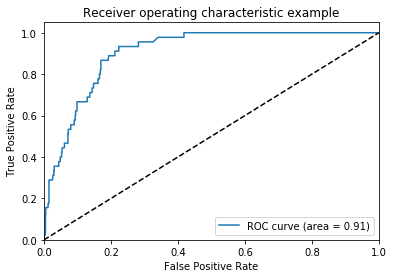

class no : 1


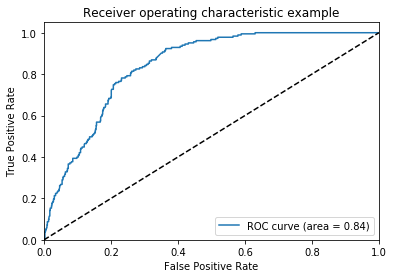

class no : 2


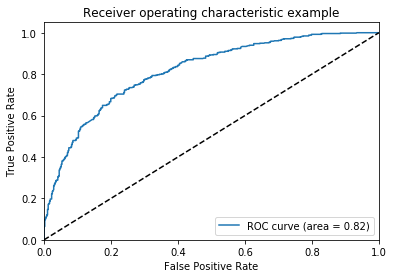

class no : 3


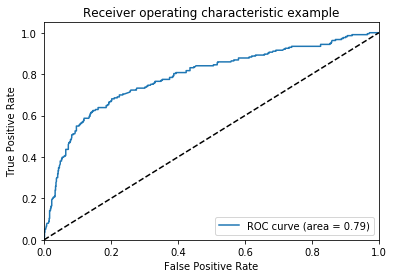

class no : 4


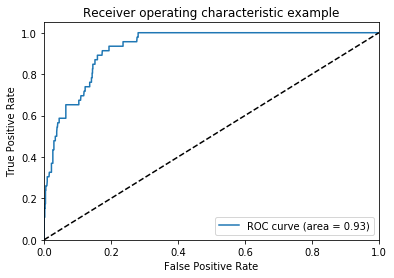

In [21]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 5

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score[:, i] , pos_label = i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    print('class no :' , i )
    
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Using area under ROC curve (AUC) as a measure of quality of the classification model: <br>
AUC for Sentiment 0 = 0.91% <br>
AUC for Sentiment 1 = 0.84% <br>
AUC for Sentiment 2 = 0.82% <br>
AUC for Sentiment 3 = 0.79% <br>
AUC for Sentiment 4 = 0.93% <br>

AUC is particularly useful for classification problems with a class imbalance, as was the case for movie reviews data in this project, where some classes had significantly less data than others (as per the EDA). <br>

Best quality of classification for the movie reviews' sentiments based on applying the model run in this notebook is for Sentiments 0 ("negative") and 4 ("positive"). An AUC of 0.8 to 0.9 is usually considered to be good at separating the class it evaluates from the other classes, thus overall this model performs well at classifying the sentiments.
